## **Importing Required Libraries**


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
import re
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
# Download necessary NLTK datasets
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading Dataset**


In [9]:
df = pd.read_csv('/content/drive/MyDrive/Dataset-SA.csv')
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


## **Data Exploration**


In [11]:
df.shape

(102526, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102526 entries, 0 to 102525
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   102526 non-null  object
 1   product_price  102526 non-null  object
 2   Rate           102526 non-null  object
 3   Review         79851 non-null   object
 4   Summary        102516 non-null  object
 5   Sentiment      102526 non-null  object
dtypes: object(6)
memory usage: 4.7+ MB


In [13]:
text = df['Review'] + ' ' + df['Summary']
sentiment = df['Sentiment']
data = pd.DataFrame({'text':text, 'sentiment':sentiment})
data.head()

,text,sentiment
0,super! great cooler excellent air flow and for...,positive
1,awesome best budget 2 fit cooler nice cooling,positive
2,fair the quality is good but the power of air ...,positive
3,useless product very bad product its a only a fan,negative
4,fair ok ok product,neutral


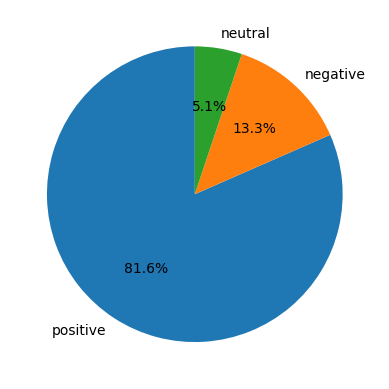

In [14]:
ValueCounter = data['sentiment'].value_counts()
plt.pie(ValueCounter, labels=ValueCounter.index, autopct='%1.1f%%', startangle=90)
plt.show()

## **Data Preprocessing**


In [15]:
# Drop neutral data and missing values
data = data.dropna()
data = data[data['sentiment'] != 'neutral']
print(data['sentiment'].value_counts())

# Create a lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean and lemmatize the text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply text preprocessing
data['text'] = data['text'].apply(lambda x: re.sub(r'(#|@)\w*', '', x))  # Remove hashtags
data['text'] = data['text'].apply(lambda x: re.sub("https?:\/\/\S+", '', x))  # Remove links
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))  # Remove special characters
data['text'] = data['text'].apply(preprocess_text)
print(data.head())

sentiment
positive    65677
negative    10240
Name: count, dtype: int64
                                                text sentiment
0  super great cooler excel air flow price amaz u...  positive
1          awesom best budget 2 fit cooler nice cool  positive
2                 fair qualiti good power air decent  positive
3                    useless product bad product fan  negative
5  awesom cooler realli fantast provid good air f...  positive


## **Feature Engineering Using TF-IDF**


In [16]:
# Convert text data into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(data['text'])
columns = tfidf.get_feature_names_out()

X = tfidf.transform(data['text']).toarray()

# Convert labels to binary (0 for negative, 1 for positive)
y = [0 if cls == 'negative' else 1 for cls in data['sentiment']]

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
dataset = list(zip(X, y))
random.shuffle(dataset)
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

## **Machine Learning model for Sentiment Analysis**


In [17]:
# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weights = dict(enumerate(class_weights))

In [18]:
# Create Decision Tree Model
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Make Predictions
preds = model.predict(X_test)

Accuracy : 96.00 %
Precision: 97.68 %
Recall   : 97.60 %
F1 Score : 97.64 %
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2309
           1       0.98      0.98      0.98     12875

    accuracy                           0.96     15184
   macro avg       0.92      0.92      0.92     15184
weighted avg       0.96      0.96      0.96     15184



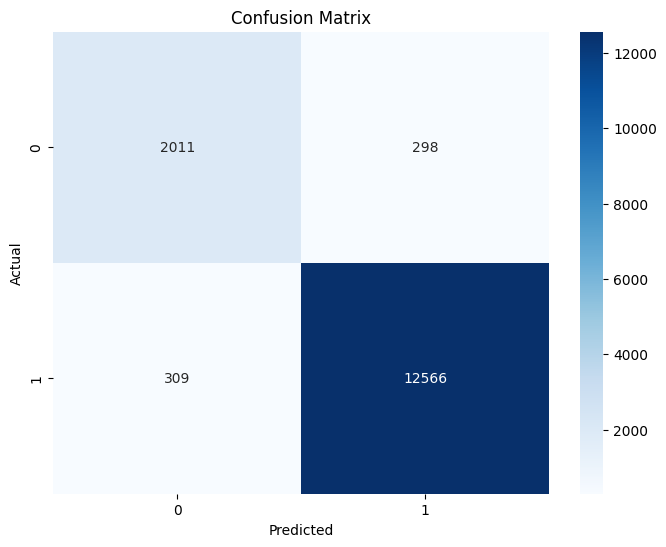

In [19]:
# Evaluate the Model
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, np.array(preds))
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
class_report = classification_report(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)

print(f"Accuracy : {accuracy * 100:.2f} %")
print(f"Precision: {precision * 100:.2f} %")
print(f"Recall   : {recall * 100:.2f} %")
print(f"F1 Score : {f1 * 100:.2f} %")
print("Classification Report:\n", class_report)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## **Save the model and other objects**


In [20]:
# with open('model.pkl', 'wb') as file:
#     pk.dump(model, file)

In [21]:
# with open('Vectorizer.pkl', 'wb') as file:
#     pk.dump(tfidf, file)
